In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import math

import nltk
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from pymongo import MongoClient
import json

In [3]:
con = MongoClient('localhost',27017)
db = con.politica

In [4]:
dataset = pd.DataFrame()

In [5]:
text_tweets = []
for tweet in db.tweets_lula.find():
    twitterText = ""
    if('retweeted_status' in tweet):
        if('extended_tweet' in tweet['retweeted_status']):
            twitterText = tweet['retweeted_status']['extended_tweet']['full_text']
        else:
            twitterText = tweet['retweeted_status']['text']

    elif('extended_tweet' in tweet):
        twitterText = tweet['extended_tweet']['full_text']
    else:
        twitterText = tweet['text']
    
    text_tweets.append(twitterText)

dataset['text'] = pd.Series(text_tweets)

In [6]:
dataset['text_processed'] = np.nan

In [7]:
stemmer = nltk.stem.RSLPStemmer()
for ind, tweet in enumerate(dataset['text']):
    t = tweet
    t = t.lower() # removendo letras maiúsculas
    t = re.sub(r'(\b)?@\w+','',t) #removendo referências a outros perfis
    t = re.sub(r'(\b)?#\w+','',t) #removendo hashtags
    t = re.sub(r'http\S+','',t,flags=re.MULTILINE) #removendo links
    t = re.sub(r'https\S+','',t,flags=re.MULTILINE) #removendo links
    t = re.sub(r'(\w+)?\d(\w+)?','',t) # removendo números
    t = re.sub(r',|\"|!|\n|:|\.|\?|;|\(|\)|#',' ',t) #removendo pontuações
    
    # removendo stopwords
    nsw = ''
    for word in t.split(' '):
        if word not in stopwords.words('portuguese'):
            nsw += word+' '
    t = nsw.strip()
    t = re.sub(r' +',' ',t) # removendo espaços duplos
    t = t.strip() # remover espaços vazios no início e no fim
    
    # isolando o radical das palavras
    if len(t) > 0:
        t = t.split(' ')
        ste = [stemmer.stem(word) for word in t]
        processedTweet = ' '.join(ste)
        dataset['text_processed'][ind] = processedTweet
    else:
        dataset['text_processed'][ind] = ''

/home/alysson/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/alysson/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [8]:
dataset.head()

,text,text_processed
0,Lula ganhou um suprêmio: só vai levar chocolat...,lul ganh suprêmi vai lev chocolat pásco
1,"- ""aécio é flagrado pedindo grana a empresário...",- aéci é flagr ped gran empres - lalalal - ass...
2,UM OMELETE PARA UM CONDENADO.\nLula apela para...,omelet conden lul apel seguranç guarda-chuv úl...
3,Denuncian ataques contra caravana de Lula en S...,denuncian ataqu contr caravan lul en sant cata...
4,O segurança do Lula com guarda-chuva porque tã...,seguranç lul guarda-chuv porqu tão dand ov nel


In [9]:
count_vect = CountVectorizer()
matrix_vectorized = count_vect.fit_transform(dataset['text_processed'].values.tolist())
print(matrix_vectorized.shape)
print(count_vect.get_feature_names()[0:10])

(5861, 6478)
['aaaaah', 'aaah', 'aaain', 'abaix', 'abaixo', 'aban', 'abandon', 'abat', 'abate', 'abc']


# Clustering with DBScan

In [10]:
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import DBSCAN

In [11]:
matrix_distances_euclidean = euclidean_distances(matrix_vectorized)
matrix_distances_euclidean.shape

(5861, 5861)

In [12]:
print("Distância euclidiana, máximo: ",matrix_distances_euclidean.max())
print("Distância euclidiana, média: ",matrix_distances_euclidean.mean())
print("Distância euclidiana, std: ",matrix_distances_euclidean.std())
print("Distância euclidiana, mínimo: ",matrix_distances_euclidean.std())

Distância euclidiana, máximo:  61.37589103222861
Distância euclidiana, média:  5.412407163864355
Distância euclidiana, std:  3.2917112944496782
Distância euclidiana, mínimo:  3.2917112944496782


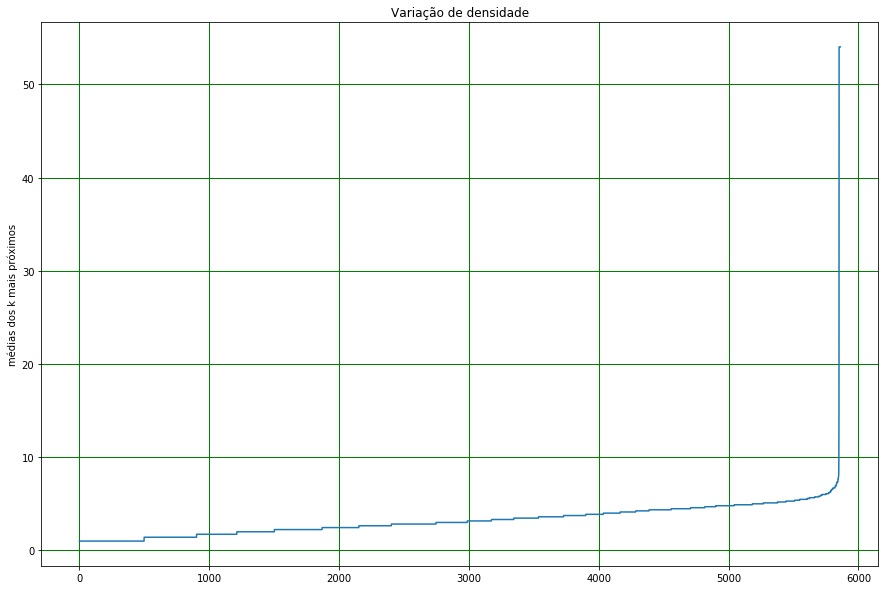

In [15]:
def k_dist(k, i, points):
    dist = []
    smaller = np.max(points)
    for i in range(0,k):
        for j in range(len(points)):
            if j != i:
                if points[j] < smaller and points[j] != 0:
                    smaller = points[j]
        dist.append(smaller)
    return np.mean(dist)

i = 0
y = []
while i < len(matrix_distances_euclidean):
    y.append(k_dist(3,i,matrix_distances_euclidean[i]))
    i += 1
y.sort()
    
plt.figure(figsize=(15,10))
plt.plot(y)
plt.grid(color='g', linestyle='-', linewidth=1)
plt.ylabel('médias dos k mais próximos')
plt.title('Variação de densidade')
plt.show()

In [13]:
minPoints = math.log(len(matrix_distances_euclidean))
dbscan_euclidean_distance = DBSCAN(eps=matrix_distances_euclidean.mean(), min_samples= minPoints, metric="precomputed")
clusters_euclidean_dbscan = dbscan_euclidean_distance.fit(matrix_distances_euclidean)
dataset['cluster_euclidean_dbscan'] = clusters_euclidean_dbscan.labels_

### Grid Search for *eps* and *minPoints*

# Clustering with Kmeans

In [57]:
# from sklearn.metrics.pairwise import euclidean_distances
# from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans

In [58]:
# kmeans_euclidean_distance = KMeans(n_clusters=3, precompute_distances=True)
kmeans_euclidean_distance = MiniBatchKMeans(n_clusters=3)
# clusters_euclidean_kmeans = kmeans_euclidean_distance.fit(matrix_distances_euclidean)
clusters_euclidean_kmeans = kmeans_euclidean_distance.fit(matrix_vectorized)
dataset['cluster_euclidean_kmeans'] = clusters_euclidean_kmeans.labels_

In [59]:
dataset.head()

,text,text_processed,cluster_euclidean_dbscan,cluster_euclidean_kmeans,polaridade
0,Lula ganhou um suprêmio: só vai levar chocolat...,lul ganh suprêmi vai lev chocolat pásco,0,0,-1
1,"- ""aécio é flagrado pedindo grana a empresário...",- aéci é flagr ped gran empres - lalalal - ass...,-1,0,-7
2,UM OMELETE PARA UM CONDENADO.\nLula apela para...,omelet conden lul apel seguranç guarda-chuv úl...,0,0,-2
3,Denuncian ataques contra caravana de Lula en S...,denuncian ataqu contr caravan lul en sant cata...,0,0,0
4,O segurança do Lula com guarda-chuva porque tã...,seguranç lul guarda-chuv porqu tão dand ov nel,0,0,-1


# Clusters

1. [Experiments on the Automatic Induction of German Semantic Verb Classes](http://www.schulteimwalde.de/research/phd.html)
**Obs:** Chapter 4: Clustering Algorithms and Evaluations

In [17]:
dataset['cluster_euclidean_dbscan'].value_counts()

 0    5538
-1     268
 1      20
 2      16
 3      10
 4       9
Name: cluster_euclidean_dbscan, dtype: int64

In [60]:
dataset['cluster_euclidean_kmeans'].value_counts()

0    5662
2     133
1      66
Name: cluster_euclidean_kmeans, dtype: int64

* ### Evaluation

In [62]:
kmeans_euclidean_distance.inertia_

116461.42615504551

In [61]:
#Silhouette Value

from sklearn.metrics import silhouette_score

silhouette_score(X=matrix_distances_euclidean,labels=kmeans_euclidean_distance.labels_)

-0.19028539392812804

In [56]:
silhouette_score(X=matrix_distances_euclidean,labels=dbscan_euclidean_distance.labels_)

0.303997982032036

* ### Polarity of the tweets

In [20]:
from Polarity import Polarity

In [21]:
Polarity.load()
Polarity.base_lexica.head()

,palavra,gn,tg,pol,anot,pos
0,"abafadas,abafado",GN=fp,TG=HUM,POL=-1,ANOT=JALC,PoS=Adj
1,"abafado,abafado",GN=ms,TG=HUM,POL=-1,ANOT=JALC,PoS=Adj
2,"abafados,abafado",GN=mp,TG=HUM,POL=-1,ANOT=JALC,PoS=Adj
3,"abafante,abafante",GN=fs,TG=HUM,POL=-1,ANOT=MAN,PoS=Adj
4,"abafante,abafante",GN=ms,TG=HUM,POL=-1,ANOT=MAN,PoS=Adj


In [22]:
dataset['polaridade'] = 0

j = 0
for tweet in dataset.text:
    twt = Polarity.preProcessor(tweet)
    score = 0
    for p in twt.split(' '):
        score += Polarity.searchWord(p)
    dataset.polaridade[j] = score
    j += 1

/home/alysson/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [23]:
dataset.head()

,text,text_processed,cluster_euclidean_dbscan,cluster_euclidean_kmeans,polaridade
0,Lula ganhou um suprêmio: só vai levar chocolat...,lul ganh suprêmi vai lev chocolat pásco,0,2,-1
1,"- ""aécio é flagrado pedindo grana a empresário...",- aéci é flagr ped gran empres - lalalal - ass...,-1,0,-7
2,UM OMELETE PARA UM CONDENADO.\nLula apela para...,omelet conden lul apel seguranç guarda-chuv úl...,0,0,-2
3,Denuncian ataques contra caravana de Lula en S...,denuncian ataqu contr caravan lul en sant cata...,0,2,0
4,O segurança do Lula com guarda-chuva porque tã...,seguranç lul guarda-chuv porqu tão dand ov nel,0,2,-1


* ### Analyzes

In [24]:
dataset.groupby('cluster_euclidean_dbscan')['polaridade'].sum()

cluster_euclidean_dbscan
-1   -1213
 0   -7645
 1      20
 2    -112
 3       0
 4     -63
Name: polaridade, dtype: int64

In [25]:
dataset.groupby('cluster_euclidean_dbscan')['polaridade'].mean()

cluster_euclidean_dbscan
-1   -4.526119
 0   -1.380462
 1    1.000000
 2   -7.000000
 3    0.000000
 4   -7.000000
Name: polaridade, dtype: float64

In [26]:
dbscan_pos,dbscan_neg,dbscan_neu = 0,0,0
clusters_dbscan = []
for i in range(-1,5):
    dbscan_pos,dbscan_neg,dbscan_neu = 0,0,0
    for v in dataset.polaridade[dataset.cluster_euclidean_dbscan[dataset.cluster_euclidean_dbscan == i].index].values:
        if v < 0:
            dbscan_neg += 1
        if v > 0:
            dbscan_pos += 1
        if v == 0:
            dbscan_neu += 1
    print('Cluster '+str(i))
    print('pos = ',str(dbscan_pos), '; neg = ',str(dbscan_neg), '; neu=',str(dbscan_neu))
    clusters_dbscan.append((dbscan_pos,dbscan_neg,dbscan_neu))

Cluster -1
pos =  44 ; neg =  210 ; neu= 14
Cluster 0
pos =  876 ; neg =  3495 ; neu= 1167
Cluster 1
pos =  20 ; neg =  0 ; neu= 0
Cluster 2
pos =  0 ; neg =  16 ; neu= 0
Cluster 3
pos =  0 ; neg =  0 ; neu= 10
Cluster 4
pos =  0 ; neg =  9 ; neu= 0


> DBScan 

Cluster | Positves | Negatives | Neutro
--------|----------|-----------|-----------|
Cluster -1| 44 | 210 | 14
Cluster 0| 876 | 3495 |1167
Cluster 1| 20 | 0 | 0
Cluster 2| 0 | 16 | 0
Cluster 3| 0 | 0 | 10
Cluster 4| 0 | 9 | 0

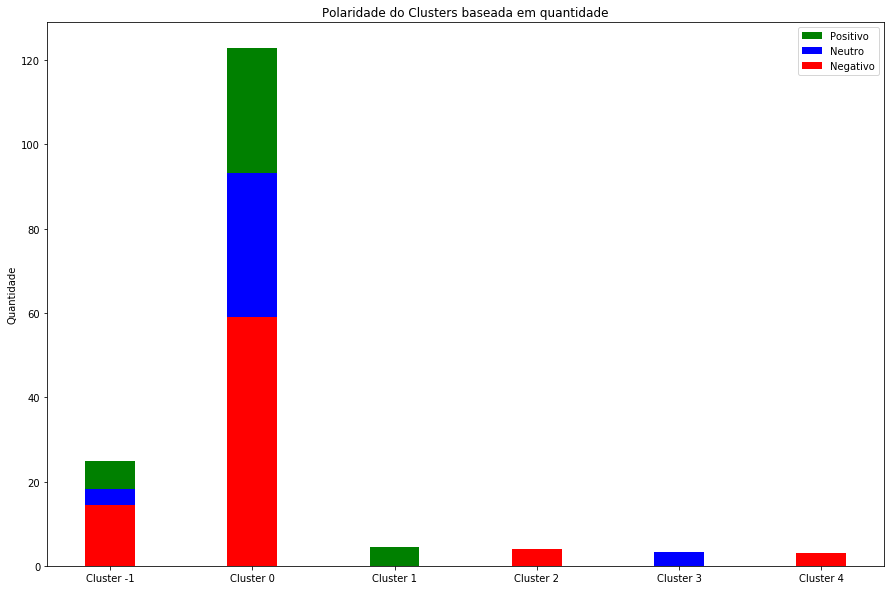

In [41]:
def normalize(t, i):
    return math.sqrt(t[i])

# Gráfico de distribuição de polaridades

C = 6
dbscan_pos = np.array([normalize(i,0) for i in clusters_dbscan])
dbscan_neg = np.array([normalize(i,1) for i in clusters_dbscan])
dbscan_neu = np.array([normalize(i,2) for i in clusters_dbscan])

ind = np.arange(C)
width = 0.35

plt.figure(figsize=(15,10))
pNeg = plt.bar(ind, dbscan_neg, width, color='r')
pNeu = plt.bar(ind, dbscan_neu, width, bottom=dbscan_neg, color='b')
pPos = plt.bar(ind, dbscan_pos, width, bottom=dbscan_neg+dbscan_neu, color='g')

plt.ylabel('Quantidade')
plt.title('Polaridade do Clusters baseada em quantidade')
plt.xticks(ind, ('Cluster -1', 'Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'))
plt.legend((pPos[0], pNeu[0], pNeg[0]), ('Positivo', 'Neutro', 'Negativo'))

plt.show()

In [42]:
# Nuvem de palavras dos clusters

from wordcloud import WordCloud

In [43]:
count_clusters_dbscan = dataset.cluster_euclidean_dbscan.value_counts().index.tolist()
count_clusters_dbscan.sort()

In [44]:
for i in count_clusters_dbscan:
    text = Polarity.preProcessor(" ".join(dataset.text[dataset.cluster_euclidean_dbscan == i].tolist()))
    
    wordcloud = WordCloud(background_color='white', max_words=2500).generate(text)

    plt.figure(figsize=(7,5))
    plt.title('Cluster '+str(i))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")

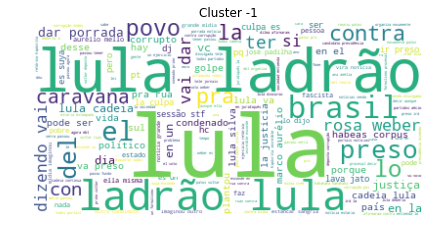

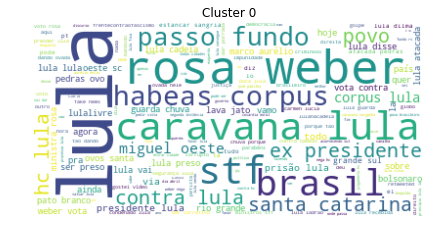

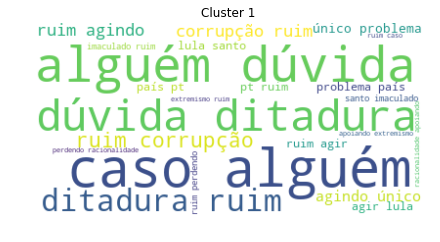

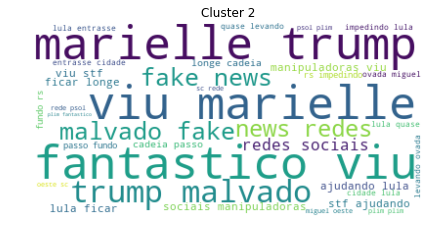

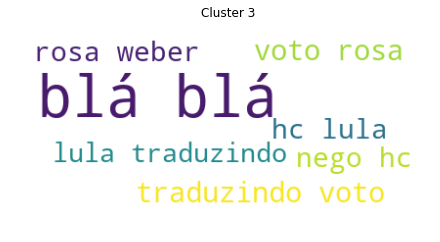

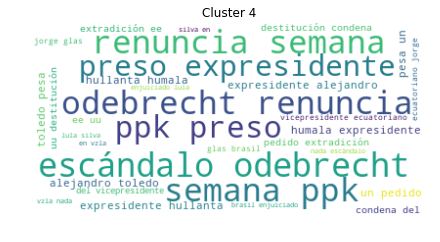

In [45]:
plt.show()

In [63]:
dataset.groupby('cluster_euclidean_kmeans')['polaridade'].sum()

cluster_euclidean_kmeans
0   -8437
1       7
2    -583
Name: polaridade, dtype: int64

In [64]:
dataset.groupby('cluster_euclidean_kmeans')['polaridade'].mean()

cluster_euclidean_kmeans
0   -1.490110
1    0.106061
2   -4.383459
Name: polaridade, dtype: float64

In [65]:
kmeans_pos,kmeans_neg,kmeans_neu = 0,0,0
clusters_kmeans = []
for i in range(0,3):
    kmeans_pos,kmeans_neg,kmeans_neu = 0,0,0
    for v in dataset.polaridade[dataset.cluster_euclidean_kmeans[dataset.cluster_euclidean_kmeans == i].index].values:
        if v < 0:
            kmeans_neg += 1
        if v > 0:
            kmeans_pos += 1
        if v == 0:
            kmeans_neu += 1
    print('Cluster '+str(i))
    print('pos = ',str(kmeans_pos), '; neg = ',str(kmeans_neg), '; neu=',str(kmeans_neu))
    clusters_kmeans.append((kmeans_pos,kmeans_neg,kmeans_neu))

Cluster 0
pos =  905 ; neg =  3603 ; neu= 1154
Cluster 1
pos =  26 ; neg =  17 ; neu= 23
Cluster 2
pos =  9 ; neg =  110 ; neu= 14


> Kmeans

Cluster | Positves | Negatives | Neutro
--------|----------|-----------|-----------|
Cluster 0| 634 | 2180 | 938
Cluster 1| 0 | 0 |10
Cluster 2| 306 | 1550 | 243

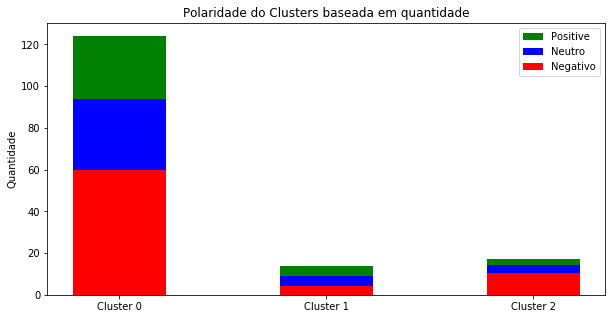

In [66]:
C = 3

kmeans_pos = np.array([normalize(i,0) for i in clusters_kmeans])
kmeans_neg = np.array([normalize(i,1) for i in clusters_kmeans])
kmeans_neu = np.array([normalize(i,2) for i in clusters_kmeans])

ind = np.arange(C)
width = 0.45

plt.figure(figsize=(10,5))
pNeg = plt.bar(ind, kmeans_neg, width, color='r')
pNeu = plt.bar(ind, kmeans_neu, width, bottom=kmeans_neg, color='b')
pPos = plt.bar(ind, kmeans_pos, width, bottom=kmeans_neg+kmeans_neu, color='g')

plt.ylabel('Quantidade')
plt.title('Polaridade do Clusters baseada em quantidade')
plt.xticks(ind, ('Cluster 0', 'Cluster 1', 'Cluster 2'))
plt.legend((pPos[0], pNeu[0], pNeg[0]), ('Positive', 'Neutro', 'Negativo'))

plt.show()

In [50]:
# Nuvem de palavras dos clusters
count_clusters_kmeans = dataset.cluster_euclidean_kmeans.value_counts().index.tolist()
count_clusters_kmeans.sort()

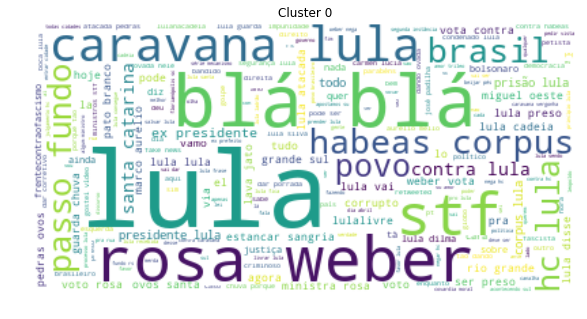

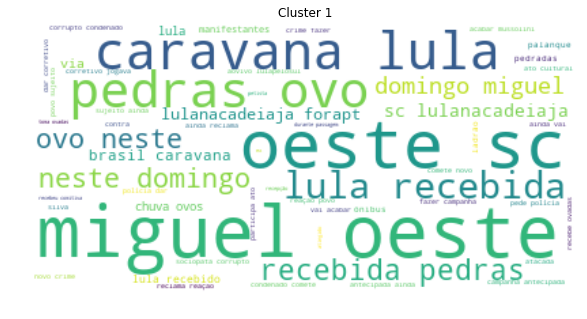

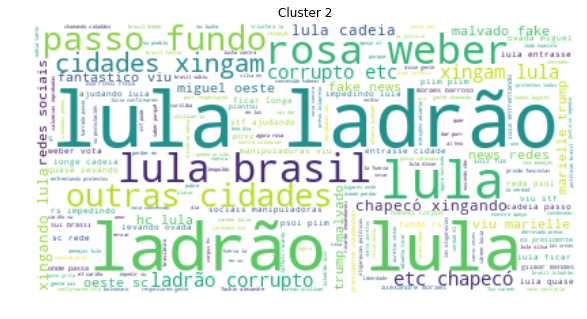

In [67]:
for i in count_clusters_kmeans:
    text = Polarity.preProcessor(" ".join(dataset.text[dataset.cluster_euclidean_kmeans == i].tolist()))
    
    wordcloud = WordCloud(background_color='white', max_words=2500).generate(text)

    plt.figure(figsize=(10,5))
    plt.title('Cluster '+str(i))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")

plt.show()